<a href="https://colab.research.google.com/github/d-atallah/implicit_gender_bias/blob/main/09_Supervised_Error_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, Download, & Variable Statements

In [12]:
# Import & download statements
# General Statements
#!git clone https://github.com/d-atallah/implicit_gender_bias.git
#! pip install joblib
#! pip install shap
import pandas as pd
import string
import re
import joblib
#from implicit_gender_bias import config as cf
import os
import numpy as np
import time
#from sklearn.externals import joblib

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import seaborn as sns

# Feature selection & Model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD,PCA, NMF
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score, accuracy_score, roc_curve, roc_auc_score, log_loss, make_scorer, average_precision_score

# Model options
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# NLTK resources
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read Inputs

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Variables
folder_path = '/content/drive/MyDrive/Supervised Learning Notebooks/'#'/home/gibsonce/datallah-jaymefis-gibsonce/'

# Load DataFrames from pkl files
y_train = pd.read_pickle(folder_path + 'y_train.pkl')
y_test = pd.read_pickle(folder_path + 'y_test.pkl')

## Define Functions


In [ ]:
# Evaluate a model
def model_eval(pipeline, X_test, y_test):
    """
    Evaluates a specified model using accuracy, precision, recall, F-1 score, AUC-ROC & PR, log-Loss, and a confusion matrix.

    Parameters:
    - pipeline (object): Fitted pipeline.
    - X_test (list or array): Test set features.
    - y_test (list or array): True labels.

    Returns:
    - metrics_df (pd.DataFrame): DataFrame containing the metrics and scores.
    - confusion_df (pd.DataFrame): DataFrame containing a confusion matrix.
    """

    start_time = time.time()

    # Create positive binary predictions
    y_pred_proba = pipeline.predict_proba(X_test)
    y_pred = (y_pred_proba >= 0.5)[:, 1].astype(int)
    print('preds created')

    # Calculate single split metrics
    f1 = f1_score(y_test, y_pred)
    auc_pr = average_precision_score(y_test, y_pred)


    #Single split evaluation
    metrics_df = pd.DataFrame({
        'Metric': ['F1-Score', 'AUC-PR'],
        'Single Split Score': [f1, auc_pr]
    })
    metrics_df = metrics_df.reset_index(drop=True)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Single split evaluation completed. Time elapsed: {elapsed_time/60:.2f} minutes.")

    # Cross-validation
    scoring = {
        'f1': make_scorer(f1_score),
        'pr_auc': make_scorer(average_precision_score),
    }
    print('cv scoring created')

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(pipeline, X_test, y_test, cv=cv, scoring=scoring)

    print('cv pipeline created')
    # Create DataFrame to store cross-validation results
    cv_metrics_df = pd.DataFrame({
    'Metric': ['F1-Score','AUC-PR'],
    'CV_Mean': [np.mean(cv_results['test_f1']),
                np.mean(cv_results['test_pr_auc']),
                ],
    'CV_Std Dev': [np.std(cv_results['test_f1']),
                   np.std(cv_results['test_pr_auc']),
                  ]
    })

    print('DF created')
    combined_metrics_df = pd.merge(metrics_df, cv_metrics_df, on='Metric')

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Cross validation completed. Time elapsed: {elapsed_time/60:.2f} minutes.")

    # Print cross-validation results
    print("\nEvaluation results:")
    print(combined_metrics_df)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_df = pd.DataFrame(cm, columns=['Predicted Positive', 'Predicted Negative'], index=['Actual Positive', 'Actual Negative'])

    print("\nConfusion Matrix:")
    print(confusion_matrix)

    return combined_metrics_df, confusion_df

In [ ]:
def model_rank(model_list, model_str, metric):
    """
    Finds the model with the best score based on a specified metric.

    Parameters:
    - models_list (list): List of dictionaries, each representing a model's details.
    - model_str (list): List of model names corresponding to models_list.
    - metric (str): Metric to rank the models by (e.g., 'Accuracy', 'F1-Score').

    Returns:
    - all_models (pd.DataFrame): DataFrame with metric scores and model names.
    - models_by_metric (pd.DataFrame): DataFrame filtered by the specified metric and sorted in descending order.
    """
    all_models = [model_dict['metrics'].assign(Model=model_name) for model_dict, model_name in zip(model_list, model_str)]

    # Concatenate the DataFrames in the list
    all_models = pd.concat(all_models, ignore_index=True)


    # Sort the DataFrame by the specified metric in descending order
    models_by_metric = all_models[all_models['Metric'] == metric].sort_values(by='Score', ascending=False)

    return all_models, models_by_metric

## XGBoost

In [ ]:
#Error analysis by pos tagging

In [40]:
model = 'xgb'
pipeline = joblib.load(f'{folder_path}{model}_pipeline.pkl')
X_test = joblib.load(f'{folder_path}{model}_X_test.pkl')
feature_importance_dict  = joblib.load(f'{folder_path}{model}_features.pkl')
misclassified_bow = joblib.load(f'{folder_path}{model}_misclassified_bow.pkl')

In [16]:
y_pred_proba = pipeline.predict_proba(X_test)
y_pred = (y_pred_proba >= 0.5)[:, 1].astype(int)
print('preds created')

preds created


In [19]:
misclassified_indices = np.where(y_test != y_pred)[0]

# Convert sparse matrix to dense array
X_test_dense = X_test.toarray()

# Extract misclassified samples
misclassified_samples = X_test_dense[misclassified_indices]
true_labels = y_test.iloc[misclassified_indices]
predicted_labels = y_pred[misclassified_indices]

## Error by POS Tagging

## Bag of Words

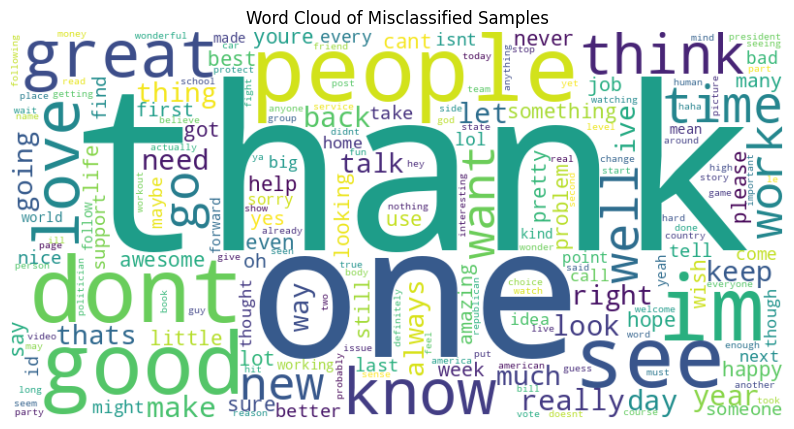

In [42]:
# Combine misclassified bag of words into a single string
misclassified_text = ' '.join(misclassified_bow)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(misclassified_text)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Misclassified Samples')
plt.show()

## Topic Modeling

In [45]:

# Convert the bag of words to a bag-of-words representation
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
misclassified_counts = vectorizer.fit_transform(misclassified_bow)

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
misclassified_topics = lda.fit_transform(misclassified_counts)

# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
print("Top words for each topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[:-5 - 1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")

Top words for each topic:
Topic #1: im, like, right, people, year
Topic #2: thank, talk, way, know, pretty
Topic #3: work, good, got, love, like
Topic #4: thanks, follow, dont, people, im
Topic #5: like, make, time, great, dont


## t-SNE

In [ ]:


# Assuming X_test_dense is your dense array of misclassified samples
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_test_dense)

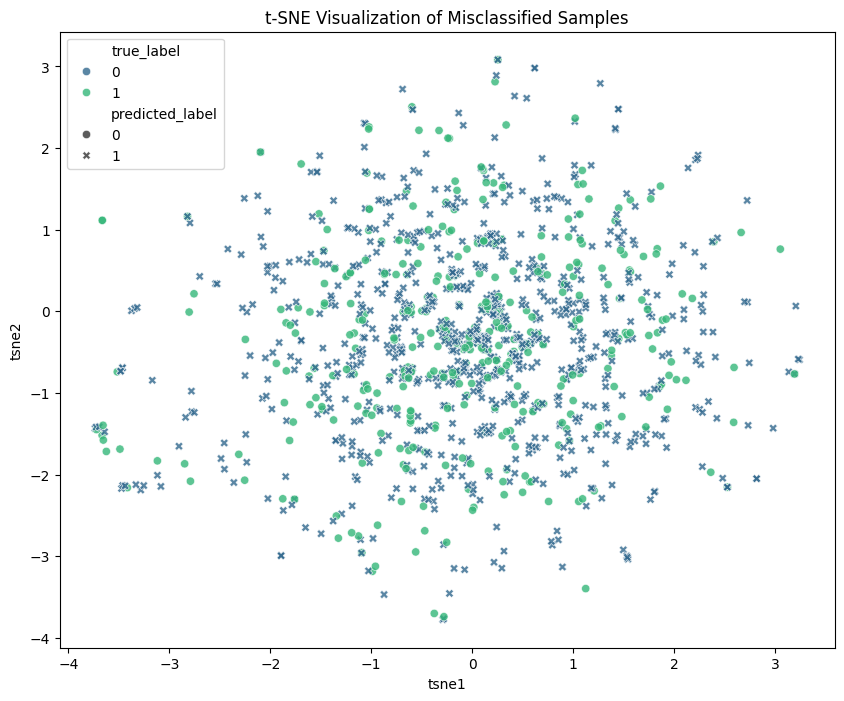

In [35]:

# Create a DataFrame with t-SNE components and true labels
tsne_df = pd.DataFrame({'tsne1': X_tsne[:, 0], 'tsne2': X_tsne[:, 1], 'true_label': true_labels, 'predicted_label': predicted_labels})

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne1', y='tsne2', hue='true_label', style='predicted_label', data=tsne_df, palette='viridis', alpha=0.8)
plt.title('t-SNE Visualization of Misclassified Samples')
plt.show()

In [25]:


# Create a DataFrame with t-SNE components and true labels
tsne_df = pd.DataFrame({'tsne1': X_tsne[:, 0], 'tsne2': X_tsne[:, 1], 'true_label': true_labels, 'predicted_label': predicted_labels})

# Plot t-SNE visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne1', y='tsne2', hue='true_label', style='predicted_label', data=tsne_df, palette='viridis', alpha=0.8)
plt.title('t-SNE Visualization of Misclassified Samples')
plt.show()

ValueError: All arrays must be of the same length